In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model

# ============================================================
# Conv2D + AE による CWT 異常検知（ラベル有/無 両対応）
# 方針：
#   ・学習と閾値決めは「Xのみ」で行う（ラベルは使わない）
#   ・ラベルは「可視化（色分け）」のときだけ使う（存在すれば）
#
# 入力（npz）想定：
#   Xcwt_tr_n: (Ntr, 64, 256, C)  # C=センサ数（例:2）
#   Xcwt_te_n: (Nte, 64, 256, C)  # C=センサ数（例:2）
#   y_tr, y_te: (N,)   ※ 無い場合もOK
# ============================================================


# ============================================================
# 0) 設定（ここだけ編集）
# ============================================================
NPZ_PATH    = "features_cwt_3.npz"
KEY_X_TR    = "Xcwt_tr_n"
KEY_X_TE    = "Xcwt_te_n"

# ラベルキー（npzに無い場合は自動で None 扱い）
KEY_Y_TR    = "y_tr"
KEY_Y_TE    = "y_te"

# ============================================================
# train split（fit / calib）
# ============================================================

FIT_RATIO = 0.7
# train（Xtr）を「学習用 fit」と「閾値決め用 calib」に分ける比率。
# 例：trainが500窓なら
#   fit  = 500 * 0.7 = 350窓（AEの学習に使う）
#   calib= 残り150窓（学習には使わず、スコア分布から閾値を決める）
# 注意：calib が少ないと ALPHA の分位点が不安定になる。
# 目安：calib は最低でも 100窓くらい欲しい（500窓なら 0.7 前後は無難）。


# ============================================================
# train params（学習の挙動を決める）
# ============================================================

LR = 1e-3
# 学習率（重み更新の1回あたりの大きさ）。
# 大きすぎる：損失が下がらない/振動/発散しやすい
# 小さすぎる：安定だが学習が遅い（同じepoch数だと学習不足になりやすい）
# 目安：まず 1e-3。安定しないなら 3e-4 や 1e-4 に下げる。

BATCH_SIZE = 64
# バッチサイズ（1回の更新でまとめて使う窓数）。
# 小さい：更新がノイズっぽい（汎化に効くこともあるが遅い）
# 大きい：更新が安定しやすい（速いことが多いが汎化が落ちる場合も）
# 今回 fit≈350窓なら 32〜64 が扱いやすい。128だとバッチ数が少なくなりがち。

EPOCHS = 100
# 最大エポック数（fitデータを何周回すかの上限）。
# 実際は PATIENCE（EarlyStopping）で途中停止するので、上限として大きめに置く値。
# 目安：100で十分。学習が遅いなら200でもよい（EarlyStoppingが止める）。

VAL_RATIO = 0.1
# fit の一部を「検証用（val）」として取り分ける割合。
# fit=350窓なら val=35窓。学習は残り315窓で実行。
# 目的：過学習の検知（train lossは下がるが val loss が下がらなくなると危険）。
# 目安：0.1 が無難。fitが少ないなら0.2も候補（ただし学習データが減る）。

PATIENCE = 8
# EarlyStopping の待ち回数。
# val_loss が改善しない状態が PATIENCE 回続いたら学習を打ち切り、
# 「最も良かったval_lossの重み」に戻す。
# 小さい：早く止まる（学習不足のリスク）
# 大きい：長く回す（時間↑だが改善点に到達する場合あり）
# 目安：5〜15。まず8は無難。

SHUFFLE = False
# 学習時に fit サンプルの順序をシャッフルするか。
# 時系列窓なら False 推奨（順序を保った方が変な混ざり方をしない）。
# ただし validation_split は「末尾側」を検証に回す挙動になりやすいので、
# データが時間で変化するなら「後半が丸ごと検証」になり得る点に注意。
# 学習が不安定なら True を試す価値はある。


# ============================================================
# threshold（calib から閾値を作る）
# ============================================================

ALPHA = 0.995
# calib スコア分布の「上側分位点」を閾値にする。
# 例：ALPHA=0.995 なら「calib の上位0.5%点」が閾値。
#   score > threshold なら異常とみなす。
# 注意：calib が150窓しかないと 0.995 はほぼ最大値に近くなり不安定。
# 目安：calibが少ない場合は 0.98〜0.99 が安定しやすい。
#       calibを増やせるなら 0.995〜0.999 も現実的。


# ============================================================
# model size（AEの表現力・計算量を決める）
# ============================================================

F1, F2, F3 = 16, 32, 64
# Conv2D のフィルタ数（特徴量の数）。
# 大きい：表現力↑（復元が上手くなる） / 計算↑ / 過学習↑ / 異常まで復元して差が出ない場合あり
# 小さい：復元が粗くなる（正常スコアも上がる） / ただし異常との差が出る場合もある
# 目安：まず 16-32-64。差が出ないなら 8-16-32 に落としてみる。

KERNEL = 3
# 畳み込みのカーネルサイズ（3なら 3x3）。
# 3x3 は基本。局所パターン（CWTの局所構造）を扱いやすい。
# 5x5 にすると広い範囲を見るが計算↑、過学習寄りになりがち。

POOL = 2
# プーリング（縮小）とアップサンプリング（拡大）の倍率。
# POOL=2 なら空間サイズが 1/2 になり、UpSampling2D(2) で元に戻す。
# いまのモデルは pool を3回行うので、
#   (64,256) -> (32,128) -> (16,64) -> (8,32)
# と圧縮される（どちらも 2^3=8 で割れるので形が崩れにくい）。

# ============================================================



In [14]:

# ============================================================
# 1) load（ラベルは「存在すれば読む」）
# ============================================================
z = np.load(NPZ_PATH, allow_pickle=False)

Xtr = z[KEY_X_TR].astype(np.float32, copy=False)
Xte = z[KEY_X_TE].astype(np.float32, copy=False)

ytr = z[KEY_Y_TR].astype(np.int32, copy=False) if KEY_Y_TR in z.files else None
yte = z[KEY_Y_TE].astype(np.int32, copy=False) if KEY_Y_TE in z.files else None

if Xtr.ndim != 4 or Xte.ndim != 4:
    raise ValueError(f"Conv2D想定は (N,H,W,C)。Xtr={Xtr.shape}, Xte={Xte.shape}")

print("Xtr:", Xtr.shape, "Xte:", Xte.shape)
print("ytr:", None if ytr is None else ytr.shape, "yte:", None if yte is None else yte.shape)



Xtr: (1000, 64, 256, 3) Xte: (1400, 64, 256, 3)
ytr: (1000,) yte: (1400,)


In [15]:

# ============================================================
# 2) train を fit / calib に分割（ラベルは一切使わない）
# ============================================================
Ntr = Xtr.shape[0]
n_fit = int(Ntr * FIT_RATIO)

X_fit = Xtr[:n_fit]
X_cal = Xtr[n_fit:]

# ラベルは可視化用に同じ分割だけする（存在する場合のみ）
y_fit = ytr[:n_fit] if ytr is not None else None
y_cal = ytr[n_fit:] if ytr is not None else None

print("X_fit:", X_fit.shape, "X_cal:", X_cal.shape, "n_fit(split index):", n_fit)


# ============================================================
# 3) Conv2D AutoEncoder
# ============================================================
inp = layers.Input(shape=X_fit.shape[1:])

x = layers.Conv2D(F1, KERNEL, padding="same", activation="relu")(inp)
x = layers.MaxPool2D(POOL, padding="same")(x)  # 32x128
x = layers.Conv2D(F2, KERNEL, padding="same", activation="relu")(x)
x = layers.MaxPool2D(POOL, padding="same")(x)  # 16x64
x = layers.Conv2D(F3, KERNEL, padding="same", activation="relu")(x)
x = layers.MaxPool2D(POOL, padding="same")(x)  # 8x32
encoded = x

x = layers.Conv2D(F3, KERNEL, padding="same", activation="relu")(encoded)
x = layers.UpSampling2D(POOL)(x)               # 16x64
x = layers.Conv2D(F2, KERNEL, padding="same", activation="relu")(x)
x = layers.UpSampling2D(POOL)(x)               # 32x128
x = layers.Conv2D(F1, KERNEL, padding="same", activation="relu")(x)
x = layers.UpSampling2D(POOL)(x)               # 64x256
out = layers.Conv2D(X_fit.shape[-1], KERNEL, padding="same", activation=None)(x)

ae = Model(inp, out)
ae.compile(optimizer=tf.keras.optimizers.Adam(LR), loss="mse")
ae.summary()


# ============================================================
# 4) 学習（fit のみ、ラベル不使用）
# ============================================================
hist = ae.fit(
    X_fit, X_fit,
    validation_split=VAL_RATIO,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True
    )],
    verbose=1
)



X_fit: (700, 64, 256, 3) X_cal: (300, 64, 256, 3) n_fit(split index): 700


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 256, 16)    │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 128, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 128, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 32, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 32, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 128, 16)    │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 64, 256, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 256, 3)     │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,035 (328.26 KB)

 Trainable params: 84,035 (328.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 0.5847 - val_loss: 0.3819
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 0.3654 - val_loss: 0.3401
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 0.3217 - val_loss: 0.2919
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.2668 - val_loss: 0.2356
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 0.2304 - val_loss: 0.2094
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.2034 - val_loss: 0.1920
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.1886 - val_loss: 0.1816
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.1775 - val_loss: 0.1705
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.1671 - val_loss: 0.1616
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 0.1596 - val_loss: 0.1609
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.1543 - val_loss: 0.1490
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2

In [16]:
# ============================================================
# 5) 異常スコア（復元誤差）
# ------------------------------------------------------------
# 入力 X は (N, 64, 256, C) で、最後の C が「センサ（チャンネル）」。
# スコアは次の2種類を作る：
#   - score_ch : (N, C)   センサごとのスコア（64x256 を平均した値）
#   - score    : (N,)     全体スコア（C方向も集約）
#
# 閾値は「全体スコア score_cal」から作る（ラベルは使わない）。
# ============================================================

# --- 全体スコアで「センサをどう集約するか」
# "mean": センサ平均（無難。Cが増えてもスケールが変わりにくい）
# "sum" : センサ和（センサ数が増えるとスケールが大きくなる）
SCORE_AGG = "mean"

def recon_score_mse_with_channels(X):
    # Xhat: (N,64,256,C)
    Xhat = ae.predict(X, batch_size=128, verbose=0)
    err = (X - Xhat) ** 2  # (N,64,256,C)

    # センサごとのスコア：空間(64x256)を平均 -> (N,C)
    score_ch = err.mean(axis=(1, 2))

    # 全体スコア：さらにチャンネル方向を集約 -> (N,)
    if SCORE_AGG == "sum":
        score = score_ch.sum(axis=1)
    else:
        score = score_ch.mean(axis=1)

    return score, score_ch

score_fit, score_fit_ch = recon_score_mse_with_channels(X_fit)
score_cal, score_cal_ch = recon_score_mse_with_channels(X_cal)
score_te,  score_te_ch  = recon_score_mse_with_channels(Xte)


# ============================================================
# 6) 閾値（calib から）
# ============================================================
thr = float(np.quantile(score_cal, ALPHA))
print(f"threshold (alpha={ALPHA}, agg={SCORE_AGG}): {thr:.6g}")
print("score_cal  min/median/max:", float(score_cal.min()), float(np.median(score_cal)), float(score_cal.max()))


threshold (alpha=0.995, agg=mean): 0.0871884
score_cal  min/median/max: 0.07639194279909134 0.08149033784866333 0.08841326832771301


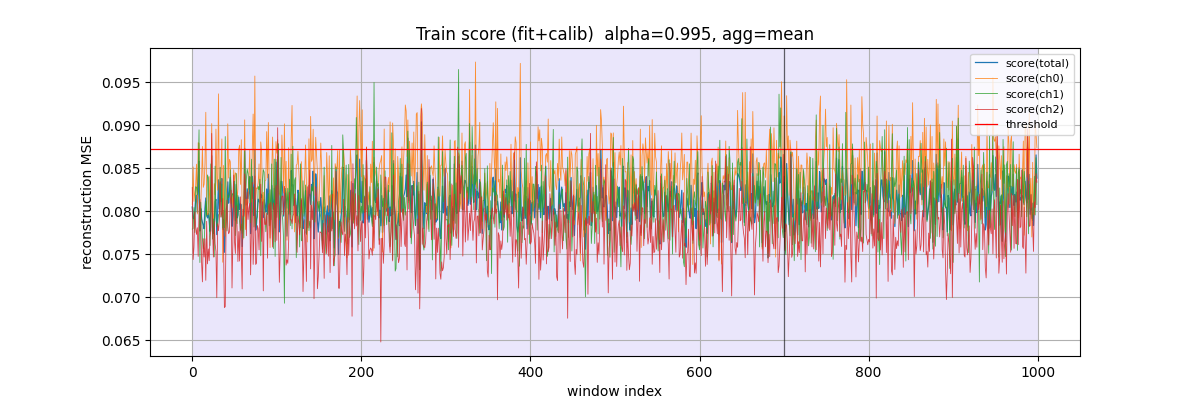

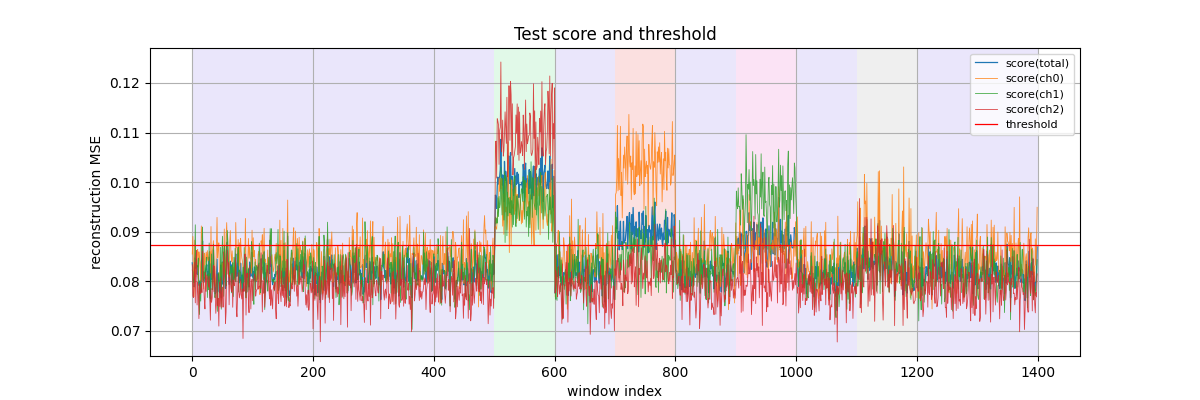

In [17]:
%matplotlib widget
# ============================================================
# 7) 可視化
#   ① 全体スコア score と閾値 thr
#   ② センサ別スコア score_ch も（必要なら）同じ図に重ねる
#   ③ ラベルがある場合は背景を色分け（区間表示）
# ============================================================

# ---- 図のサイズ（インチ）
FIGSIZE = (12, 4)

# ---- 背景色の透明度（0〜1）
BG_ALPHA = 0.12

# ---- ラベル→色（必要なら追加）
LABEL_COLOR = {
    -1: "#201919",  # ラベル無し
     0: "#5839E0",  # 例: 正常
     1: "#0DCE47",  # 例: 異常1
     2: "#E60404",  # 例: 異常2
     3: "#DF1EAF",  # 例: 異常3
}

# ---- センサ別スコアも描くか
PLOT_PER_CHANNEL = True

def _paint_label_background(ax, y, color_map, alpha=BG_ALPHA):
    """
    y: (N,) のラベル配列（Noneなら何もしない）
    同じラベルが続く区間をまとめて axvspan で塗る。
    color_map は {label: "#RRGGBB"} を想定。
    """
    if y is None:
        return
    y = np.asarray(y)
    if y.ndim != 1 or y.size == 0:
        return

    start = 0
    cur = int(y[0])

    for i in range(1, len(y) + 1):
        if i == len(y) or int(y[i]) != cur:
            col = color_map.get(cur, "#808080")  # 未定義ラベルは灰
            ax.axvspan(start, i, color=col, alpha=alpha, linewidth=0)
            start = i
            if i < len(y):
                cur = int(y[i])

def _plot_scores(ax, x, score, score_ch, title):
    # 全体スコア
    ax.plot(x, score, linewidth=0.9, label="score(total)")

    # センサ別（チャンネル別）
    if PLOT_PER_CHANNEL and (score_ch is not None):
        C = score_ch.shape[1]
        for c in range(C):
            ax.plot(x, score_ch[:, c], linewidth=0.6, alpha=0.85, label=f"score(ch{c})")

    # 閾値
    ax.axhline(thr, linewidth=0.9, color="red", label="threshold")

    ax.set_title(title)
    ax.set_xlabel("window index")
    ax.set_ylabel("reconstruction MSE")
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=8, frameon=True)

# ---- train: fit+calib
x_tr = np.arange(len(score_fit) + len(score_cal))
score_tr = np.r_[score_fit, score_cal]
score_tr_ch = np.r_[score_fit_ch, score_cal_ch]

y_tr_plot = np.r_[y_fit, y_cal] if (y_fit is not None and y_cal is not None) else None

fig, ax = plt.subplots(figsize=FIGSIZE)
_paint_label_background(ax, y_tr_plot, LABEL_COLOR)
_plot_scores(ax, x_tr, score_tr, score_tr_ch, f"Train score (fit+calib)  alpha={ALPHA}, agg={SCORE_AGG}")
ax.axvline(len(score_fit), linewidth=0.9, color="black", alpha=0.6)  # fit/calib境界
plt.show()

# ---- test
x_te = np.arange(len(score_te))

fig, ax = plt.subplots(figsize=FIGSIZE)
_paint_label_background(ax, yte, LABEL_COLOR)
_plot_scores(ax, x_te, score_te, score_te_ch, "Test score and threshold")
plt.show()


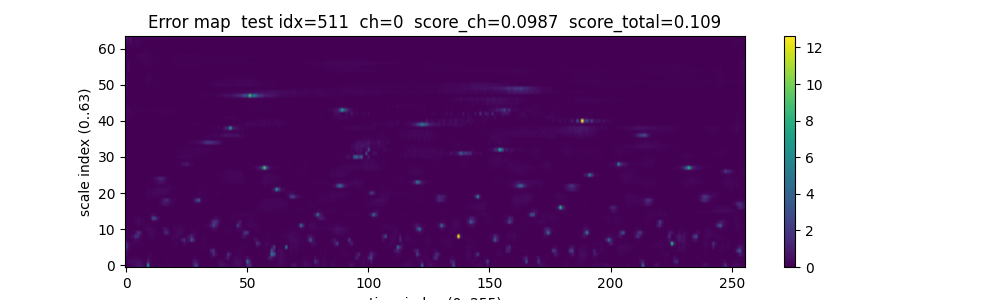

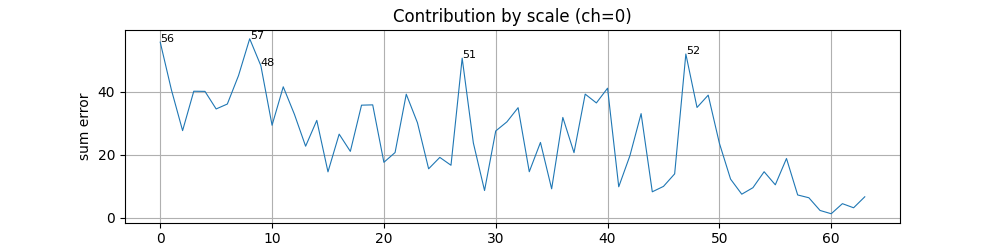

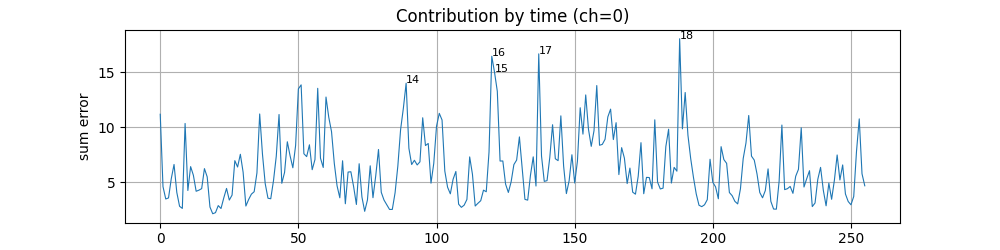

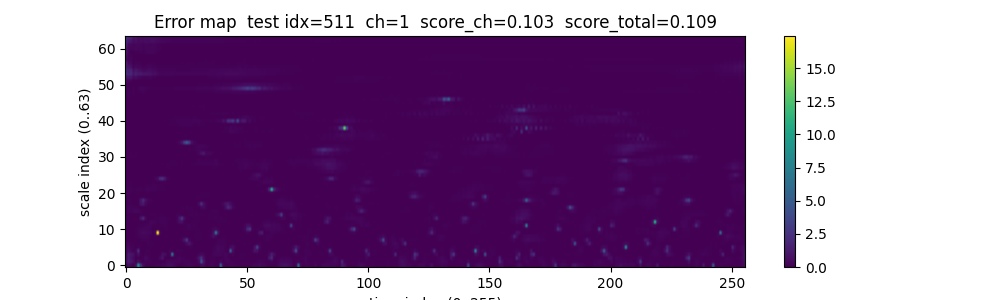

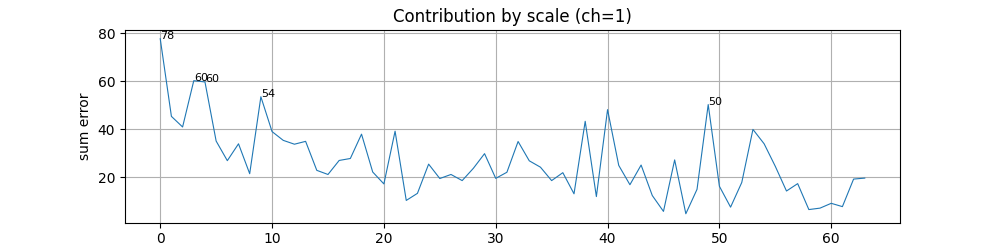

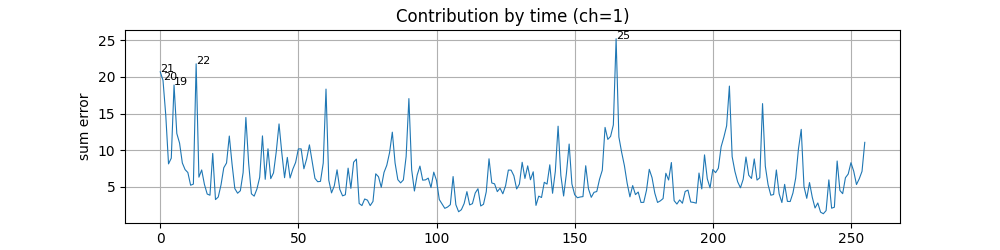

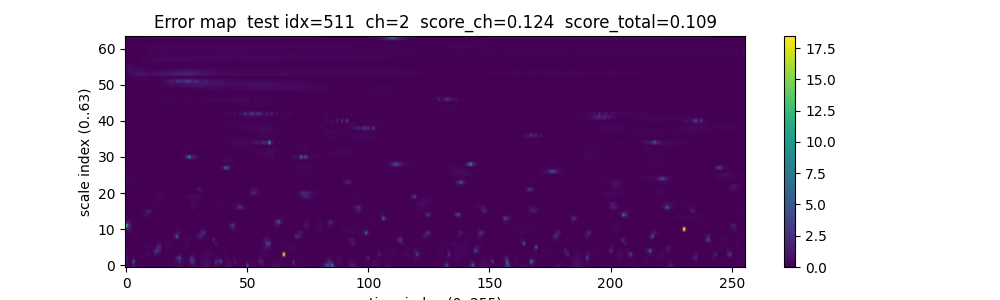

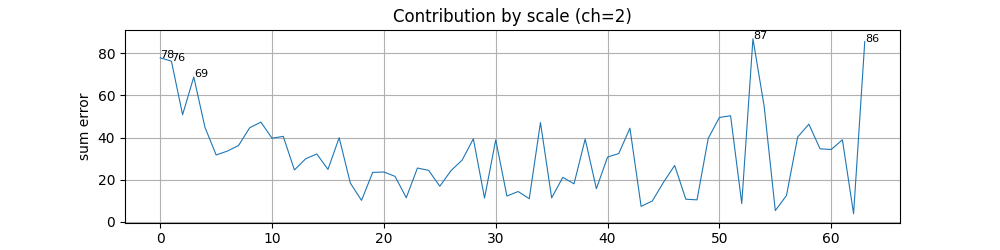

C:\Users\tsenz\AppData\Local\Temp\ipykernel_15936\3222937551.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 2.5))


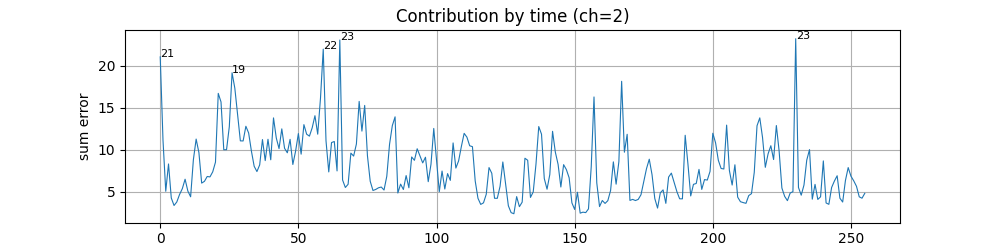

In [18]:
# ============================================================
# 8) （任意）②の代替：復元誤差マップで「どこが効いたか」を見る
# ------------------------------------------------------------
# PCAの「寄与率・因子負荷量」を AE にそのまま移すことはできないが、
# AEでは「復元誤差がどの時間×スケールに集中したか」を示すのが実務的。
#
# ここでは test のスコア上位の窓を1つ選び、
#   - センサごとの誤差マップ (64x256)
#   - スケール寄与（64）
#   - 時間寄与（256）
# を表示する。
# ============================================================

# どの窓を可視化するか（test）
TOP_RANK = 0  # 0なら最大スコア、1なら2番目...

def recon_error_map(X):
    """
    X: (N,64,256,C)
    return:
      E: (N,64,256,C)  各点の二乗誤差
    """
    Xhat = ae.predict(X, batch_size=128, verbose=0)
    return (X - Xhat) ** 2

idx_sorted = np.argsort(score_te)[::-1]
i0 = int(idx_sorted[TOP_RANK])

E = recon_error_map(Xte[[i0]])[0]  # (64,256,C)
C = E.shape[-1]

for c in range(C):
    E_c = E[..., c]  # (64,256)

    # 画像（誤差マップ）
    plt.figure(figsize=(10, 3))
    plt.imshow(E_c, aspect="auto", origin="lower")
    plt.title(f"Error map  test idx={i0}  ch={c}  score_ch={score_te_ch[i0, c]:.3g}  score_total={score_te[i0]:.3g}")
    plt.xlabel("time index (0..255)")
    plt.ylabel("scale index (0..63)")
    plt.colorbar()
    plt.show()

    # 寄与：スケール方向（64）と時間方向（256）
    contrib_scale = E_c.sum(axis=1)
    contrib_time  = E_c.sum(axis=0)

    plt.figure(figsize=(10, 2.5))
    x = np.arange(len(contrib_scale))
    plt.plot(x, contrib_scale, linewidth=0.8)
    plt.title(f"Contribution by scale (ch={c})")
    plt.xlabel("scale index")
    plt.ylabel("sum error")
    plt.grid(True)
    # 上位5点に数値を表示
    top_idx = np.argsort(contrib_scale)[::-1][:5]
    for j in top_idx:
        plt.text(j, contrib_scale[j], f"{contrib_scale[j]:.2g}", fontsize=8)
    plt.show()

    plt.figure(figsize=(10, 2.5))
    x = np.arange(len(contrib_time))
    plt.plot(x, contrib_time, linewidth=0.8)
    plt.title(f"Contribution by time (ch={c})")
    plt.xlabel("time index")
    plt.ylabel("sum error")
    plt.grid(True)
    top_idx = np.argsort(contrib_time)[::-1][:5]
    for j in top_idx:
        plt.text(j, contrib_time[j], f"{contrib_time[j]:.2g}", fontsize=8)
    plt.show()
